## pytorch完整流程

### 数据读取
* 如果是一个类别一个文件夹，则可以使用ImageFolder
* 如果特殊数据集，则需要自定义一个数据集类，用于数据的加载、预处理等，并实现len，getitem等方法

In [6]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
from torch import nn
import torchvision
from torchvision import datasets, transforms, models
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

### 先解压文件

In [7]:
import zipfile

zip_file_path = 'tiny-imagenet-200.zip'
extract_path = 'tiny-imagenet-200/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

### 原始数据集是目标检测数据集，需要：
1. 删掉训练集每个类别文件夹下的检测框txt文件,同时把所有图片直接放到类别文件夹下不再单独放到iamge文件夹中
2. 同时测试集的结构也要调整成与训练集一样的结构

In [8]:
import os

root_dir = "tiny-imagenet-200/train"  # 根目录
for subdir, dirs, files in os.walk(root_dir):
    for file in files:
        if file.endswith(".txt"):
            file_path = os.path.join(subdir, file)  # 拼接成完整路径
            os.remove(file_path)

In [9]:
import os
import shutil

# 定义根目录
train_dir = 'tiny-imagenet-200/train'

# 遍历 train 目录下的所有子文件夹
for class_folder in os.listdir(train_dir):
    class_folder_path = os.path.join(train_dir, class_folder)

    # 检查是否是文件夹
    if os.path.isdir(class_folder_path):
        images_folder = os.path.join(class_folder_path, 'images')

        # 如果 'images' 文件夹存在，则将图片移动到上一级目录，并删除 'images' 文件夹
        if os.path.exists(images_folder):
            # 遍历 images 文件夹中的所有图片
            for img_file in os.listdir(images_folder):
                img_path = os.path.join(images_folder, img_file)
                # 移动图片到类别文件夹
                shutil.move(img_path, class_folder_path)

            # 删除空的 images 文件夹
            os.rmdir(images_folder)

print("所有图片已成功移到对应的类别文件夹中，并删除了空的 'images' 文件夹。")

所有图片已成功移到对应的类别文件夹中，并删除了空的 'images' 文件夹。


In [10]:
import os
import shutil

# 定义文件夹路径
val_dir = 'tiny-imagenet-200/val'                               # val 文件夹路径
images_dir = os.path.join(val_dir, 'images')   # 存放图片的 images 文件夹路径
annotations_file = os.path.join(val_dir, 'val_annotations.txt')  # 标注文件路径

# Step 1: 解析 val_annotations.txt，创建字典映射：{图片名: 类别名}
annotations_dict = {}  # 用于存放图片名和类别名的映射
with open(annotations_file, 'r') as file:
    for line in file:
        parts = line.strip().split('\t')
        filename, class_name = parts[0], parts[1]
        annotations_dict[filename] = class_name

# Step 2: 遍历 annotations_dict，根据类别创建文件夹，并将图片移动到对应文件夹中
for filename, class_name in annotations_dict.items():
    # 创建类别文件夹
    class_folder = os.path.join(val_dir, class_name)
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)

    # 构建图片的源路径和目标路径
    src_path = os.path.join(images_dir, filename)
    dst_path = os.path.join(class_folder, filename)

    # 移动图片到对应的类别文件夹中
    if os.path.exists(src_path):
        shutil.move(src_path, dst_path)

# Step 3: 删除空的 images 文件夹（可选）
if os.path.exists(images_dir) and not os.listdir(images_dir):
    os.rmdir(images_dir)
    
# 手动删除val_annotations.txt文件

print("图片已按照类别成功分类到各自的文件夹中。")


FileNotFoundError: [Errno 2] No such file or directory: 'tiny-imagenet-200/val\\val_annotations.txt'

### 到现在所有的训练集和测试集的数据存储格式就都符合ImageFolder的要求了，可以进行数据预处理操作了
* 数据增强，使用ImageFolder，需要指定数据集和transform，transform定义了图片如何被预处理

In [11]:
data_transform = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),   # 随机旋转-45°-45°
        transforms.CenterCrop(224),     # 从中心开始裁剪，留下224*224大小
        transforms.RandomHorizontalFlip(0.5),   # 随机水平翻转的概率
        transforms.RandomVerticalFlip(0.5),     # 随机垂直翻转的概率
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # 亮度， 对比度，饱和度，色相
        transforms.RandomGrayscale(p=0.025),    # 随机转换成灰度图的概率
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 均值， 标准差（是因为在使用别人训练好的模型时，人家做了这些操作）
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 这个操作必须和训练集的一致
    ])
}

### 构建batch数据集，利用ImageFolder和定义的transform构建数据集

In [12]:
data_dir = 'tiny-imagenet-200'
batch_size = 8

# 构建数据集（需要数据集路径和使用的transform）和加载数据集的loader
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['train', 'val']} 
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'val']}
datasets_size = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes   # 查看训练集中类别

In [14]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 100000
     Root location: tiny-imagenet-200\train
     StandardTransform
 Transform: Compose(
                RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
                RandomGrayscale(p=0.025)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 10000
     Root location: tiny-imagenet-200\val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485

In [15]:
class_names

['n01443537',
 'n01629819',
 'n01641577',
 'n01644900',
 'n01698640',
 'n01742172',
 'n01768244',
 'n01770393',
 'n01774384',
 'n01774750',
 'n01784675',
 'n01855672',
 'n01882714',
 'n01910747',
 'n01917289',
 'n01944390',
 'n01945685',
 'n01950731',
 'n01983481',
 'n01984695',
 'n02002724',
 'n02056570',
 'n02058221',
 'n02074367',
 'n02085620',
 'n02094433',
 'n02099601',
 'n02099712',
 'n02106662',
 'n02113799',
 'n02123045',
 'n02123394',
 'n02124075',
 'n02125311',
 'n02129165',
 'n02132136',
 'n02165456',
 'n02190166',
 'n02206856',
 'n02226429',
 'n02231487',
 'n02233338',
 'n02236044',
 'n02268443',
 'n02279972',
 'n02281406',
 'n02321529',
 'n02364673',
 'n02395406',
 'n02403003',
 'n02410509',
 'n02415577',
 'n02423022',
 'n02437312',
 'n02480495',
 'n02481823',
 'n02486410',
 'n02504458',
 'n02509815',
 'n02666196',
 'n02669723',
 'n02699494',
 'n02730930',
 'n02769748',
 'n02788148',
 'n02791270',
 'n02793495',
 'n02795169',
 'n02802426',
 'n02808440',
 'n02814533',
 'n028

In [16]:
datasets_size

{'train': 100000, 'val': 10000}

In [17]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1cd361a08d0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x1cd5f4e3290>}

### 查看被预处理后的图片原始的样子

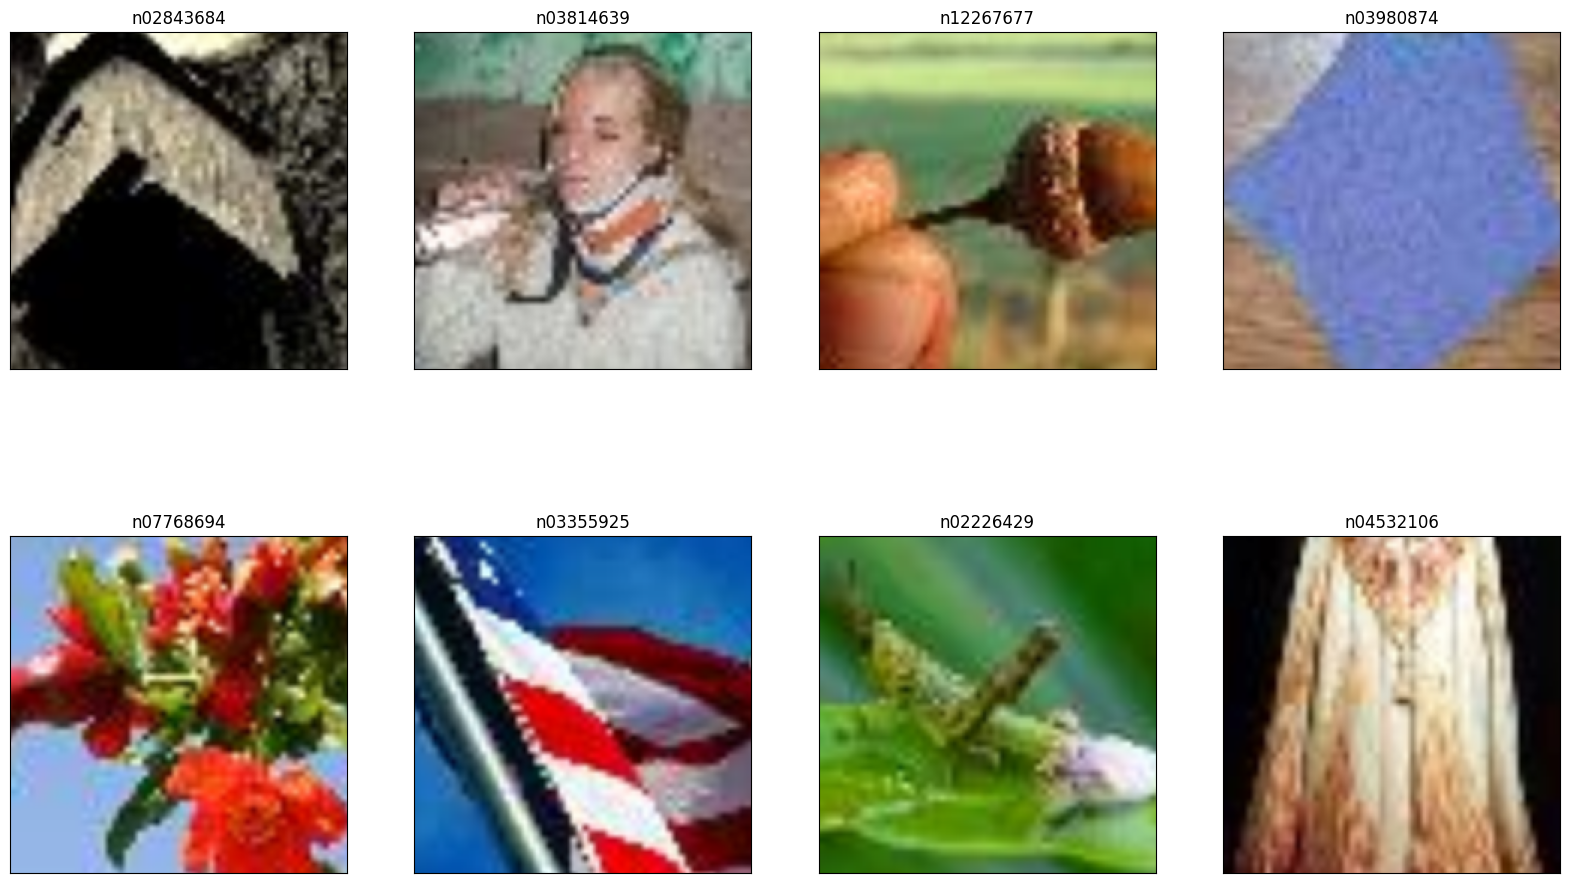

In [18]:
def image_convert(tensor):
    # 需要把预处理的操作反着来23
    image = tensor.to('cpu').clone().detach()
    image = image.numpy().squeeze() # sequeeze可以去掉batch这个维度
    image = image.transpose((1, 2, 0))  # 改变通道顺序，C0 H1 W2 变成 H1 W2 C0
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))   # 预处理的公式是normalized_image = (image - mean) / std
    image = image.clip(0, 1)    # 限制图片的每个像素值都在0-1范围内
    return image

fig = plt.figure(figsize=(20, 12))  # 设置整个画布大小为20*12英寸
columns = 4
rows = 2

dataiter = iter(dataloaders['val'])
inputs, classes = next(dataiter)
for idx in range(columns * rows):
    ax = fig.add_subplot(rows, columns, idx + 1, xticks=[], yticks=[])  # 创建子图，并指定子图的索引
    ax.set_title(class_names[classes[idx]])
    plt.imshow(image_convert(inputs[idx]))
plt.show()

### 开始使用迁移学习构建CNN网络进行分类任务
* 分别介绍改变所有参数、只改变全连接层的参数和改变部分参数的情况

In [19]:
model_name = 'resnet'   # 指定要使用的预训练模型
feature_extract = True  # True就是都不更新，False就是全部更新

def set_parameter_requires_grad(model, feature_extract):
    # 选择哪些层在训练的时候不更新, 这里的策略就是冻结所有模型参数不更新
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False

In [20]:
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if train_on_gpu else "cpu")

In [21]:
model_ft = models.resnet18()
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 修改部分层来适合自己的任务（200分类）

In [22]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 加载不同的预训练模型初始化稍微有些区别，参考pytorch官网
    model_ft = None
    input_size = 0
    
    if model_name == 'resnet':
        # resnet18
        model_ft = models.resnet18(pretrained=use_pretrained)   # 加载要使用的预训练模型
        set_parameter_requires_grad(model_ft, feature_extract)  # 定义自己更新参数的策略，调用前面定义过的冻结所有模型参数除了全连接层自己定义
        num_ftrs = model_ft.fc.in_features  # 这里先获取原始网络中全连接层的输入大小（2048）
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes), nn.LogSoftmax(dim=1)) # 重新定义自己的全连接层，输入大小就是上一步获取的，输出就是自己分类任务的数量，200
        input_size = 224 # 这个任务里的输入图片大小经过预处理后是224（先resize成256，再中心裁剪成224
        
        return model_ft, input_size

In [23]:
model_ft, input_size = initialize_model(model_name, 200, feature_extract, use_pretrained=True)
model_ft.to(device)

saved_path = "checkpoint.pth" # 保存自己微调后的模型参数

# 查看训练哪些层
params_to_update = model_ft.parameters()
print('params_to_update:')
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print('\t', name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print('\t', name)

E:\Anaconda3\envs\ai-self-learning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
E:\Anaconda3\envs\ai-self-learning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


params_to_update:
	 fc.0.weight
	 fc.0.bias


In [24]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 优化器配置

In [25]:
optimizer = optim.Adam(params_to_update, lr=1e-2)
schedule = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # 学习率每7个衰减成原来的1/10
criterion = nn.NLLLoss()    # 前面全连接层的最后是LogSoftmax，所以用NLLLoss，加起来相当于交叉熵了

### 开始训练

In [26]:
epochs = 1

def train(model, dataloaders, criterion, optimizer, epochs, is_inception=False, saved_path=saved_path):
    start_time = time.time()
    best_acc = 0    # 用于保存最好的模型权重
    
    model.to(device)
    
    val_acc_history = []
    val_loss_history = []
    train_acc_history = []
    train_loss_history = []
    LRs = [optimizer.param_groups[0]['lr']] # 存储每次的学习率方便展示
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(epochs):
        print(f"Epoch {epoch}/{epochs}\n")
        print(f"{'-'*10}")
        
        # 训练和验证
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            # 取出所有的数据
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # 清除之前的梯度
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):  # 使用自己定义参数控制什么时候更新参数
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _, preds = torch.max(outputs, 1)    # 取到预测的结果，即预测的类别的索引，并用于计算准确率
                    
                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(dataloaders[phase].dataset) # 计算每一轮的损失和准确率
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            running_time = time.time() - start_time # 计算每一轮花费的时间
            print(f"花费的时间:{running_time // 60:.0f}m {running_time % 60:.0f}s")
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            
            # 获取最好的那次模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                    'state_dict': model.state_dict(),
                    'best_acc': best_acc,
                    'optimizer': optimizer.state_dict(),
                }
                torch.save(state, saved_path)
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
                schedule.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
        
        print(f'Optimizer lr: {optimizer.param_groups[0]["lr"]:.7f}')
        LRs.append(optimizer.param_groups[0]['lr'])
    time_elapsed = time.time() - start_time
    print(f"本次训练一共花费{time_elapsed // 60:.4f}m, {time_elapsed % 60:.4f}s")
    print(f"最好的验证集准确率:{best_acc:.4f}")
    
    model.load_state_dict(best_model_wts)   # 使用完后直接返回最好的一次结果
    
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history, LRs

In [27]:
model, val_acc_history, val_loss_history, train_acc_history, train_loss_history, LRs = train(model_ft, dataloaders, criterion, optimizer, epochs)

Epoch 0/1

----------
花费的时间:49m 7s
train Loss: 14.3149 Acc: 0.0369
花费的时间:53m 7s
val Loss: 25.7352 Acc: 0.0122
Optimizer lr: 0.0000100
本次训练一共花费53.0000m, 7.1538s
最好的验证集准确率:0.0122


E:\Anaconda3\envs\ai-self-learning\Lib\site-packages\torch\optim\lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
